# Parallel execution

## EZyRB modules combined with PyCOMPSs

`EZyRB` modules:
* For reduction: POD - AE - AE_EDDL
* For approximation: Linear - RBF - GPR - Neighbors Regressor - Radius Neighbors Regressor - ANN

`PyCOMPSs` is used to convert some methods to tasks that can be executed simultaneously in different worker nodes, which is useful in case of error calculation and multiple predictions.

<img src="./pictures/1.png"> 

## Input data:

The dataset used in this example is the result of a high-fidelity solution for a 2D flow around a cylinder. The following picture shows the simultaneous execution of 18 different setups, each performing 3 predictions.

<img src="./pictures/2.png" align="center">

## Example:

In [1]:
import pycompss.interactive as ipycompss

import os
if 'BINDER_SERVICE_HOST' in os.environ:
    ipycompss.start(graph=True, debug=True,
                    project_xml='../xml/project.xml',
                    resources_xml='../xml/resources.xml')
else:
    ipycompss.start(graph=True, monitor=1000)#, debug=True, trace=False)

********************************************************
**************** PyCOMPSs Interactive ******************
********************************************************
*          .-~~-.--.           ______        ______    *
*         :         )         |____  \      /  __  \   *
*   .~ ~ -.\       /.- ~~ .      __) |      | |  | |   *
*   >       `.   .'       <     |__  |      | |  | |   *
*  (         .- -.         )   ____) |   _  | |__| |   *
*   `- -.-~  `- -'  ~-.- -'   |______/  |_| \______/   *
*     (        :        )           _ _ .-:            *
*      ~--.    :    .--~        .-~  .-~  }            *
*          ~-.-^-.-~ \_      .~  .-~   .~              *
*                   \ \ '     \ '_ _ -~                *
*                    \`.\`.    //                      *
*           . - ~ ~-.__\`.\`-.//                       *
*       .-~   . - ~  }~ ~ ~-.~-.                       *
*     .' .-~      .-~       :/~-.~-./:                 *
*    /_~_ _ . - ~              

max cells 3066
pts shape (3067, 3)
Param Mat shape (59, 1), Snap Mat sape (59, 3067)


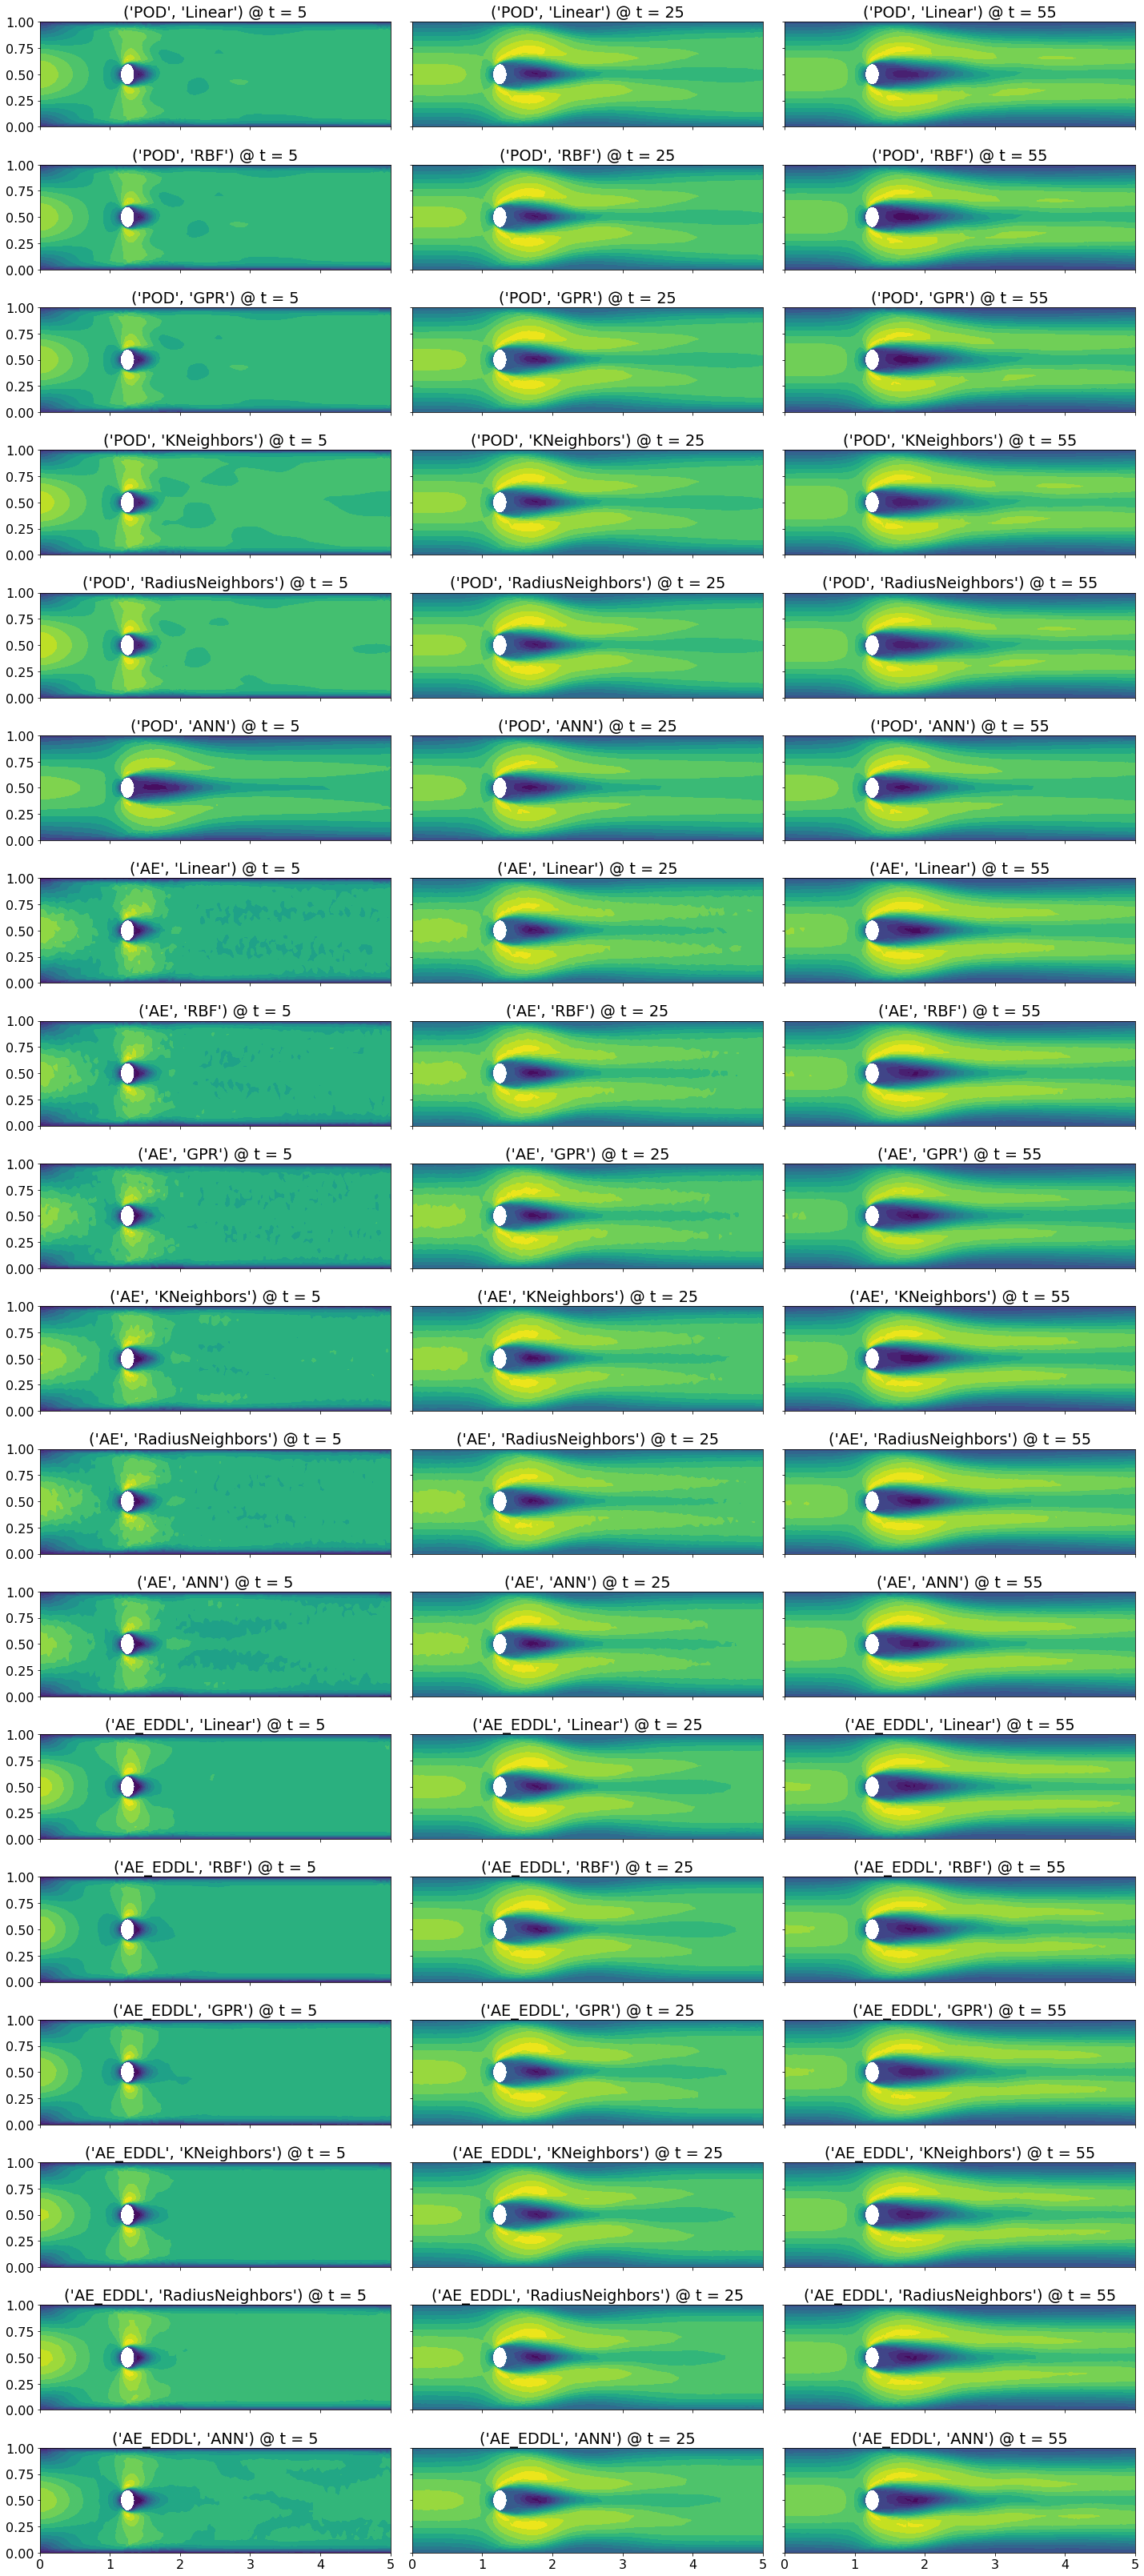

In [2]:
# Libraries
import sys       # Path to find PyEDDL library in PyCOMPSs container
sys.path.append('/usr/local/miniconda3/lib/python3.8/site-packages') 

from pycompss.api.api import compss_wait_on

from pyeddl import eddl

import torch
from torch import nn

import numpy as np
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
plt.rc('font', size = 16)

from ezyrb import Database
from ezyrb.parallel import ReducedOrderModel as ROM
from ezyrb.parallel import POD, AE, AE_EDDL, Linear, RBF, GPR, KNeighborsRegressor, RadiusNeighborsRegressor, ANN
# ----------------------------------------------------------------
# Load data as NumPy arrays:
# The snapshots represented in rows
time = np.load('./data_2d/time.npy')
pts = np.load('./data_2d/pts.npy')
cells = np.load('./data_2d/cells.npy')
snapshots_pressure = np.load('./data_2d/snapshots_pressure.npy')
snapshots_vx = np.load('./data_2d/snapshots_vx.npy')
snapshots_vy = np.load('./data_2d/snapshots_vy.npy')
snapshots_vz = np.load('./data_2d/snapshots_vz.npy')

print('max cells',np.max(cells))
print('pts shape', pts.shape)
triang = mtri.Triangulation(pts[:, 0], pts[:, 1], triangles=cells)
print('Param Mat shape {}, Snap Mat sape {}'.format(time.shape, snapshots_vx.shape))
# ----------------------------------------------------------------
# Remove snap 55 
snapshots_vx_train = np.delete(snapshots_vx,55,0)
time_train = np.delete(time,55,0)
# ----------------------------------------------------------------
db = Database(time_train, snapshots_vx_train)

# Independent instances of the approximation classes
approximations_1 = {
   'Linear': Linear(),
    'RBF': RBF(),
    'GPR': GPR(),
    'KNeighbors': KNeighborsRegressor(),
    'RadiusNeighbors':  RadiusNeighborsRegressor(),
    'ANN': ANN([500, 100, 4], nn.Tanh(), [10000,1e-5]),
}
approximations_2 = {
   'Linear': Linear(),
    'RBF': RBF(),
    'GPR': GPR(),
    'KNeighbors': KNeighborsRegressor(),
    'RadiusNeighbors':  RadiusNeighborsRegressor(),
    'ANN': ANN([500, 100, 4], nn.Tanh(), [10000,1e-5]),
}
approximations_3 = {
   'Linear': Linear(),
    'RBF': RBF(),
    'GPR': GPR(),
    'KNeighbors': KNeighborsRegressor(),
    'RadiusNeighbors':  RadiusNeighborsRegressor(),
    'ANN': ANN([500, 100, 4], nn.Tanh(), [10000,1e-5]),
}
# ----------------------------------------------------------------
l = [5,25,55]; predictions = []; methods = [];

for approxname, approxclass in approximations_1.items():
    pod = POD('svd',rank=4)
    rom = ROM(db, pod, approxclass)
    rom.fit()
    methods.append(("POD",approxname))
    for element in l:
        predictions.append(rom.predict([element]))

for approxname, approxclass in approximations_2.items():
    ae = AE([500,100,4], [4,100,500], nn.Tanh(), nn.Tanh(),
            1000, optimizer=torch.optim.Adam, lr=1e-4)
    rom = ROM(db, ae, approxclass)
    rom.fit()
    methods.append(("AE",approxname))
    for element in l:
        predictions.append(rom.predict([element]))

for approxname, approxclass in approximations_3.items():
    ae = AE_EDDL([500,100,4], [4,100,500], eddl.Tanh, eddl.Tanh,
             1000, 5, optimizer=eddl.adam, lr=1e-4,
             cs=eddl.CS_CPU, training_type=2)
    rom = ROM(db, ae, approxclass)
    rom.fit()
    methods.append(("AE_EDDL",approxname))
    for element in l:
        predictions.append(rom.predict([element]))
# ----------------------------------------------------------------
predictions= compss_wait_on(predictions)

fig, ax = plt.subplots(nrows=18, ncols=3, figsize=(20, 45), sharey=True, sharex=True)
ax = ax.flatten()
j = 0;
for i in range(54):
    ax[i].tricontourf(triang, predictions[i], levels=16)
    ax[i].set_title('{} @ t = {}'.format(methods[j], l[(i) % 3]))
    if (i+1) % 3 == 0: j+=1
plt.tight_layout()

In [3]:
ipycompss.stop(sync=True)

********************************************************
*************** STOPPING PyCOMPSs ******************
********************************************************
Checking if any issue happened.
Synchronizing all future objects left on the user scope.
Found a list to synchronize: l
Found a list to synchronize: predictions
Found a list to synchronize: methods
********************************************************
